In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.1 MB/s eta 0:00:0000:01


In [2]:
import os
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import cv2
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix
import torch
from torch_geometric.data import Data
from scipy.spatial import Delaunay
from skimage.transform import resize
from torch_geometric.loader import DataLoader
from torch.nn import Linear, ReLU
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool
import networkx as nx
import requests
from PIL import Image
import io
from skimage.segmentation import slic
from skimage.measure import regionprops
import kagglehub
from pathlib import Path
import shutil

2025-05-04 14:24:27.188317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746368667.380707      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746368667.433806      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Sử dụng: {device}")

🔧 Sử dụng: cuda


In [4]:
# target_dir = Path("data/intel-image-classification")

In [5]:
# if target_dir.exists():
#     print("✅ Dữ liệu đã tồn tại tại:", target_dir)
# else:
#     print("⬇️ Đang tải dữ liệu từ Kaggle...")
#     # Tải về thư mục mặc định của kagglehub (~/.cache/kagglehub/...)
#     downloaded_path = kagglehub.dataset_download("puneet6060/intel-image-classification")

#     # Di chuyển toàn bộ nội dung vào thư mục 'data/intel-image-classification'
#     shutil.copytree(downloaded_path, target_dir)
#     print("✅ Dữ liệu đã được lưu tại:", target_dir)

In [6]:
## ========================= Run on local =========================
# train_path = './data/intel-image-classification/seg_train/'
# test_path = './data/intel-image-classification/seg_test/'
# pred_path = './data/intel-image-classification/seg_pred/'

## ========================= Run on Kaggle =========================

train_path = '/kaggle/input/intel-image-classification/seg_train/'
test_path = '/kaggle/input/intel-image-classification/seg_test/'
pred_path = '/kaggle/input/intel-image-classification/seg_pred/'


In [7]:
def open_folders(path, file, name = 'Traning Data'):
    for folder in os.listdir(path + file):
        files = gb.glob(pathname = path + file + '/' + folder + '/*.jpg')
        print(f'{name} : Tìm thấy {len(files)} ảnh trong thư mục {folder}')

print('-' * 40 + ' Traning Data ' + '-' * 46)
open_folders(train_path, 'seg_train')
print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
open_folders(test_path, 'seg_test', name = 'Test Data')
print('\n' +'-' * 40 + ' Prediction Data ' + '-' * 44)
files = gb.glob(pathname = pred_path + 'seg_pred' + '/*.jpg')
print(f'Prediction Data : Tìm thấy {len(files)} ảnh trong thư mục Prediction')

---------------------------------------- Traning Data ----------------------------------------------
Traning Data : Tìm thấy 2512 ảnh trong thư mục mountain
Traning Data : Tìm thấy 2382 ảnh trong thư mục street
Traning Data : Tìm thấy 2191 ảnh trong thư mục buildings
Traning Data : Tìm thấy 2274 ảnh trong thư mục sea
Traning Data : Tìm thấy 2271 ảnh trong thư mục forest
Traning Data : Tìm thấy 2404 ảnh trong thư mục glacier

---------------------------------------- Test Data --------------------------------------------------
Test Data : Tìm thấy 525 ảnh trong thư mục mountain
Test Data : Tìm thấy 501 ảnh trong thư mục street
Test Data : Tìm thấy 437 ảnh trong thư mục buildings
Test Data : Tìm thấy 510 ảnh trong thư mục sea
Test Data : Tìm thấy 474 ảnh trong thư mục forest
Test Data : Tìm thấy 553 ảnh trong thư mục glacier

---------------------------------------- Prediction Data --------------------------------------------
Prediction Data : Tìm thấy 7301 ảnh trong thư mục Prediction


In [8]:
def get_image_size(path, folder_name):
    size = []
    if folder_name != 'seg_pred':
        for folder in os.listdir(path + folder_name):
            files = gb.glob(pathname = path + folder_name + '/' + folder + '/*.jpg')
            for file in files:
                image = plt.imread(file)
                size.append(image.shape)
    else:
        files = gb.glob(pathname = path + folder_name + '/*.jpg')
        for file in files:
            image = plt.imread(file)
            size.append(image.shape)

    print(pd.Series(size).value_counts())

print('-' * 40 + ' Traning Data ' + '-' * 46)
get_image_size(train_path, 'seg_train')
print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
get_image_size(test_path, 'seg_test')
print('\n' +'-' * 40 + ' Prediction Data ' + '-' * 44)
get_image_size(pred_path, 'seg_pred')


---------------------------------------- Traning Data ----------------------------------------------
(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(144, 150, 3)        2
(143, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(108, 150, 3)        2
(136, 150, 3)        2
(134, 150, 3)        2
(146, 150, 3)        2
(100, 150, 3)        1
(141, 150, 3)        1
(103, 150, 3)        1
(145, 150, 3)        1
(147, 150, 3)        1
(131, 150, 3)        1
(81, 150, 3)         1
(140, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(149, 150, 3)        1
(110, 150, 3)        1
(105, 150, 3)        1
(97, 150, 3)         1
(120, 150, 3)        1
(76, 150, 3)         1
(119, 150, 3)        1
(102, 150, 3)        1
Name: count, dtype: int64

---------------------------------------- Test Data --------------------------------------------------
(150, 150, 3)    2993
(81, 150, 3)        1
(131, 150, 3)

In [9]:
# Get Image In Arrays And Resize Images
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_name(code_number):
    for key, value in code.items():
        if code_number == value:
            return key

In [10]:
new_size = 100
def get_image_array(path, folder_name, new_size = new_size):
    X = []
    y = []
    if folder_name != 'seg_pred':
        for folder in os.listdir(path + folder_name):
            files = gb.glob(pathname= path + folder_name + '/' + folder + '/*.jpg')
            for file in files:
                image = cv2.imread(file)
                image_array = cv2.resize(image, (new_size, new_size))
                X.append(list(image_array))
                y.append(code[folder])
    else :
        files = gb.glob(pathname= path + folder_name + '/*.jpg')
        for file in files:
            image = cv2.imread(file)
            image_array = cv2.resize(image, (new_size, new_size))
            X.append(list(image_array))
    return X, y

In [11]:
X_train, y_train = get_image_array(train_path, 'seg_train')
X_test, y_test = get_image_array(test_path, 'seg_test')
X_pred, y_pred = get_image_array(pred_path, 'seg_pred')

print('-' * 40 + ' Traning Data ' + '-' * 46)
print(f'Có {len(X_train)} files X_train')
print(f'Có {len(y_train)} files y_train ')

print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
print(f'Có {len(X_test)} files X_test')
print(f'Có {len(y_test)} files y_test')

print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
print(f'Có {len(X_pred)} files X_pred')
print(f'Có {len(y_pred)} files y_pred')
def plot_some_image(X, y, name):
    print('-' * 77 + f' {name} Data ' + '-' * 77)
    plt.figure(figsize = (20, 30))
    for n, i in enumerate(list(np.random.randint(0, len(X), 9))):
        plt.subplot(3, 3, n+1)
        plt.imshow(X[i])
        plt.axis('off')
        if name != 'Prediction':
            plt.title(get_name(y[i]), fontdict = {'fontsize': 18, 'color': 'red'})


---------------------------------------- Traning Data ----------------------------------------------
Có 14034 files X_train
Có 14034 files y_train 

---------------------------------------- Test Data --------------------------------------------------
Có 3000 files X_test
Có 3000 files y_test

---------------------------------------- Test Data --------------------------------------------------
Có 7301 files X_pred
Có 0 files y_pred


----------------------------------------------------------------------------- Traning Data -----------------------------------------------------------------------------


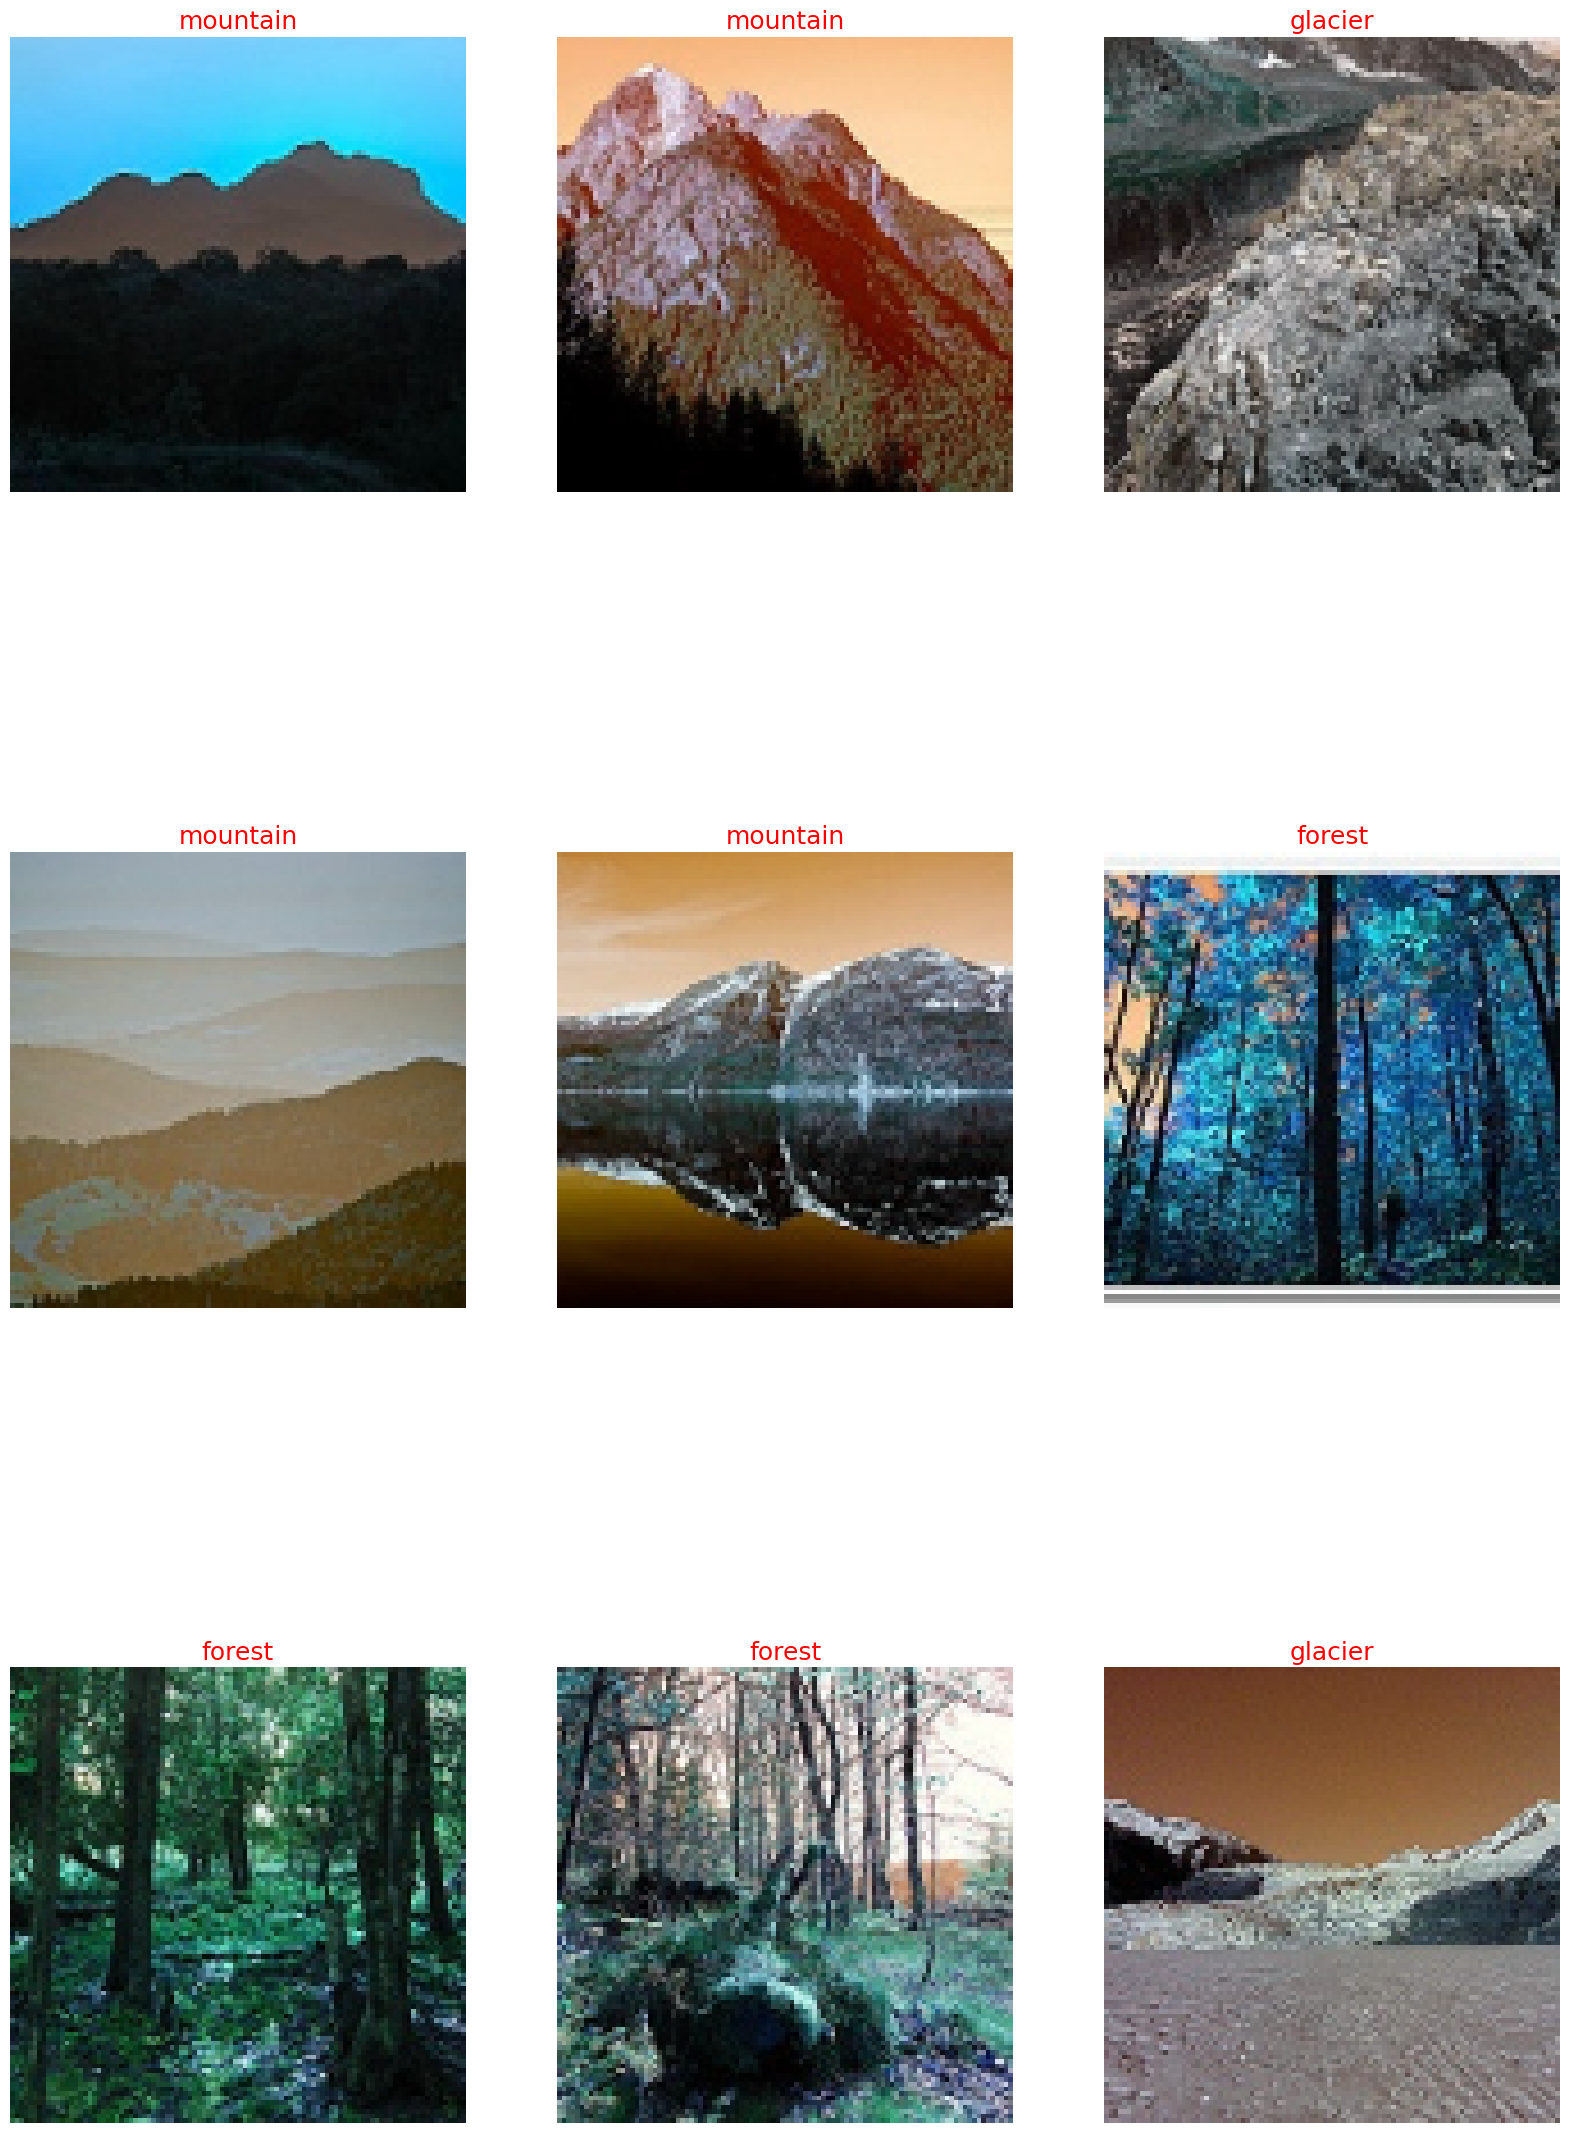

In [12]:
plot_some_image(X_train, y_train, name = 'Traning')

----------------------------------------------------------------------------- Test Data -----------------------------------------------------------------------------


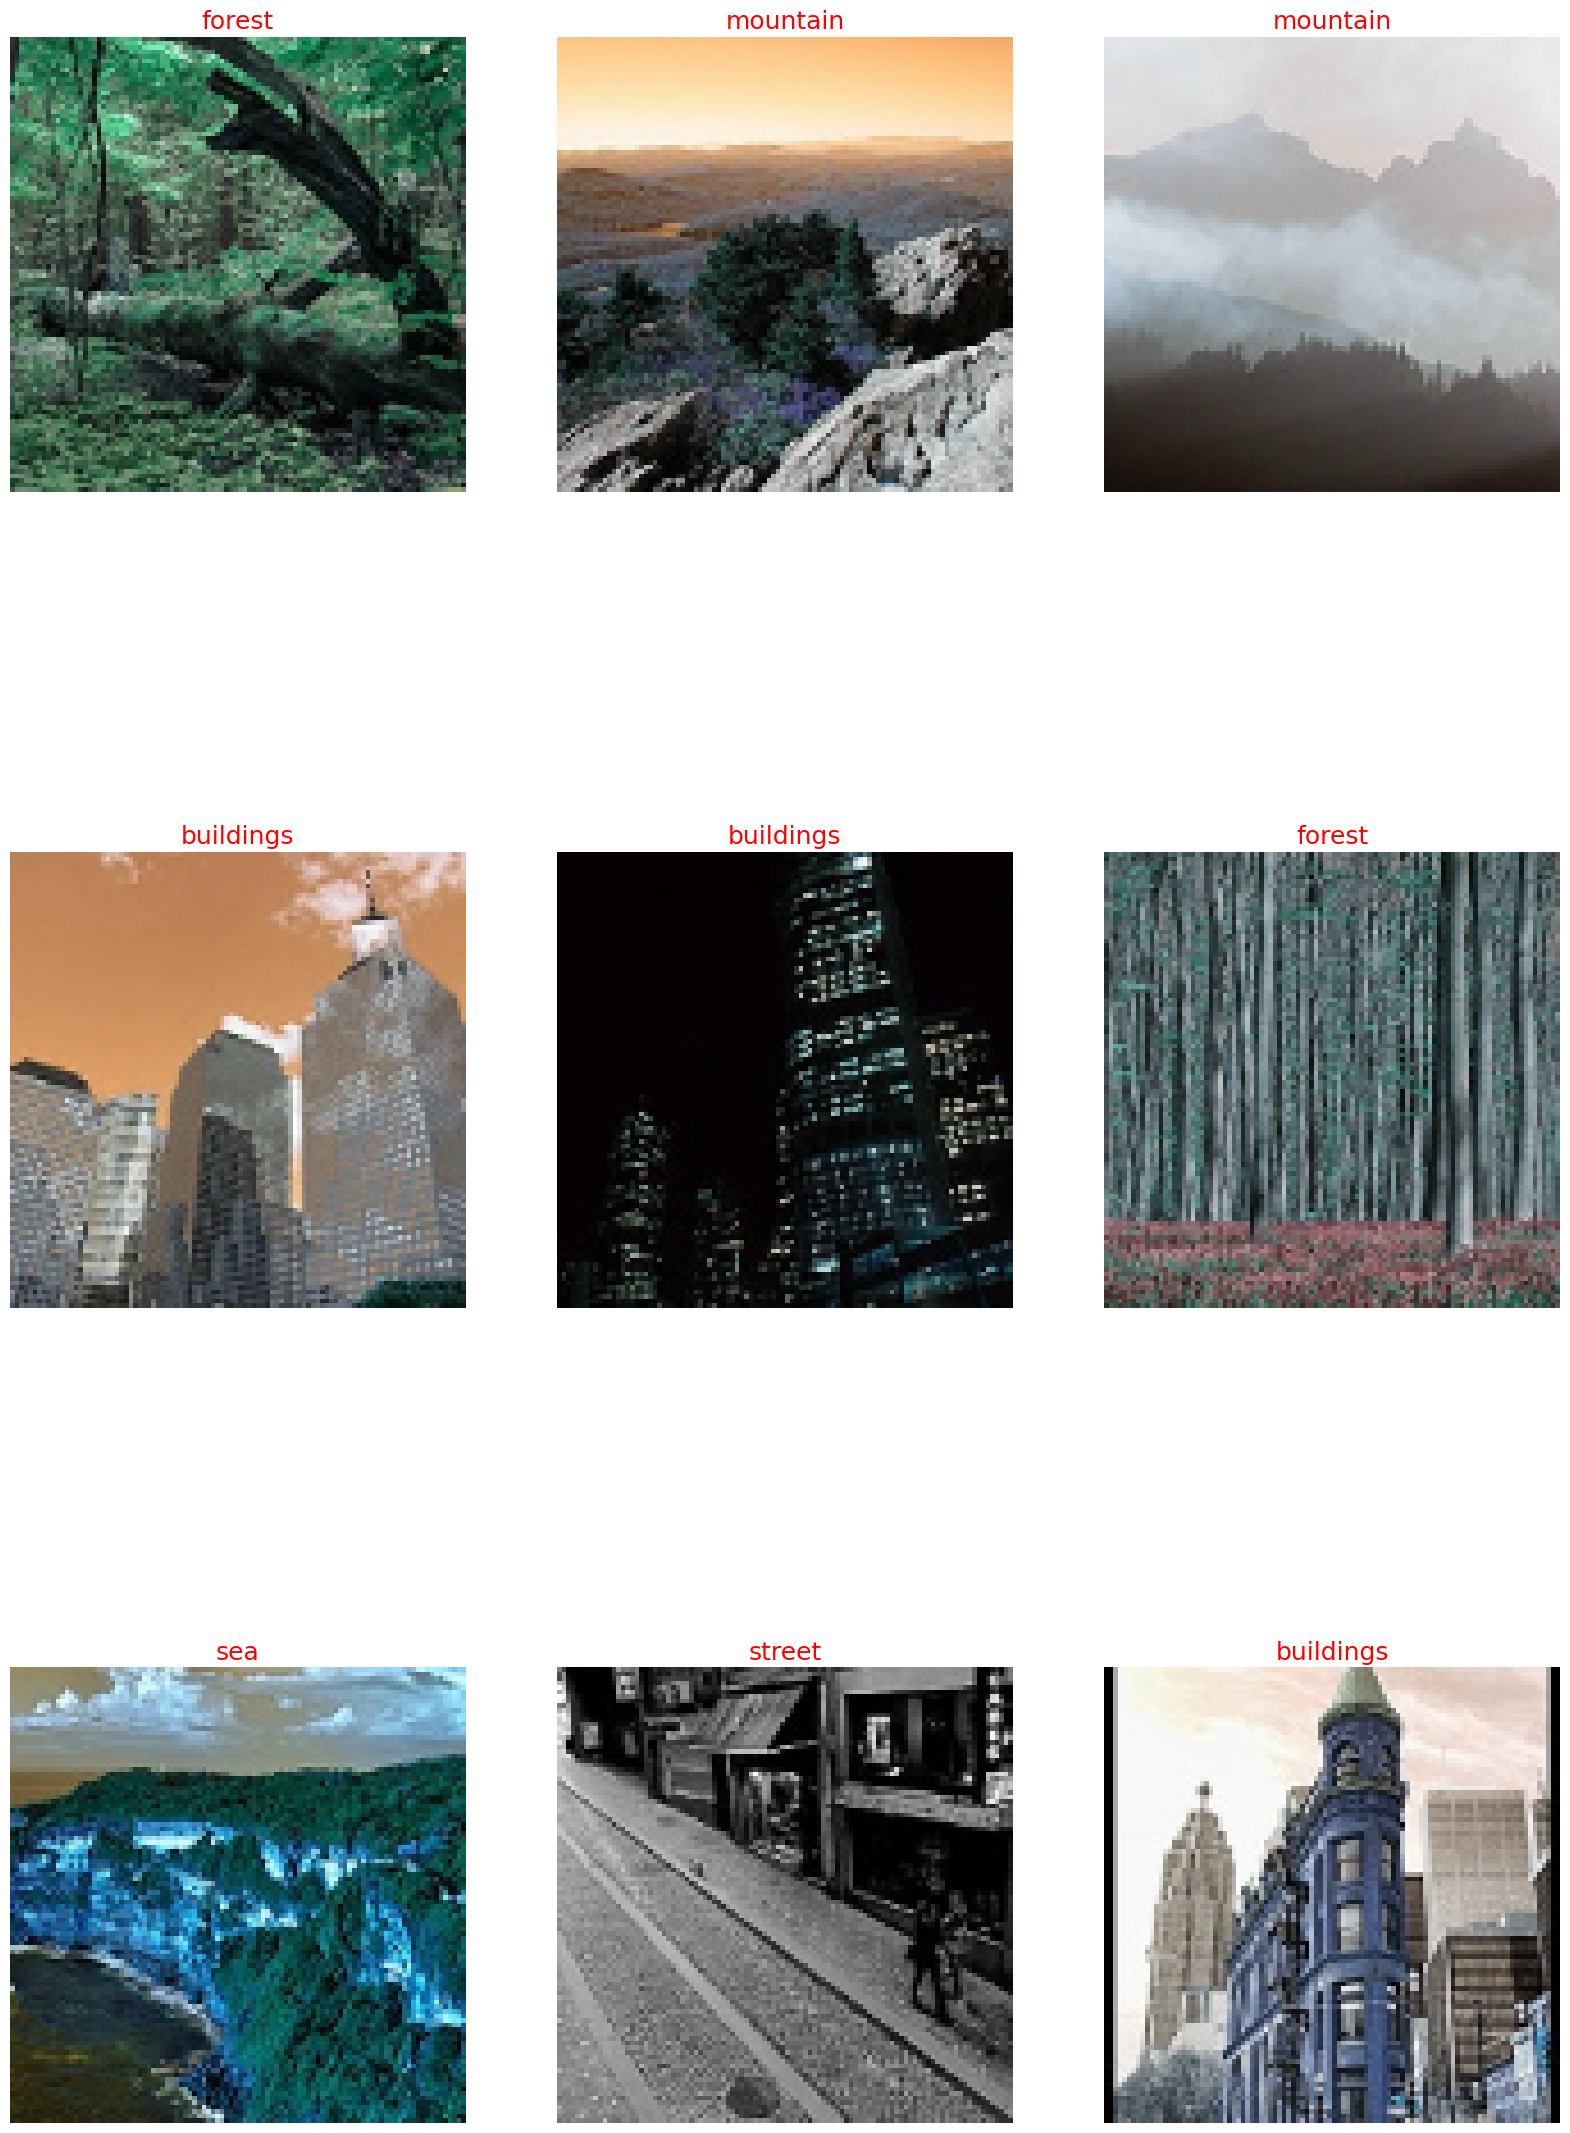

In [13]:
plot_some_image(X_test, y_test, 'Test')

----------------------------------------------------------------------------- Prediction Data -----------------------------------------------------------------------------


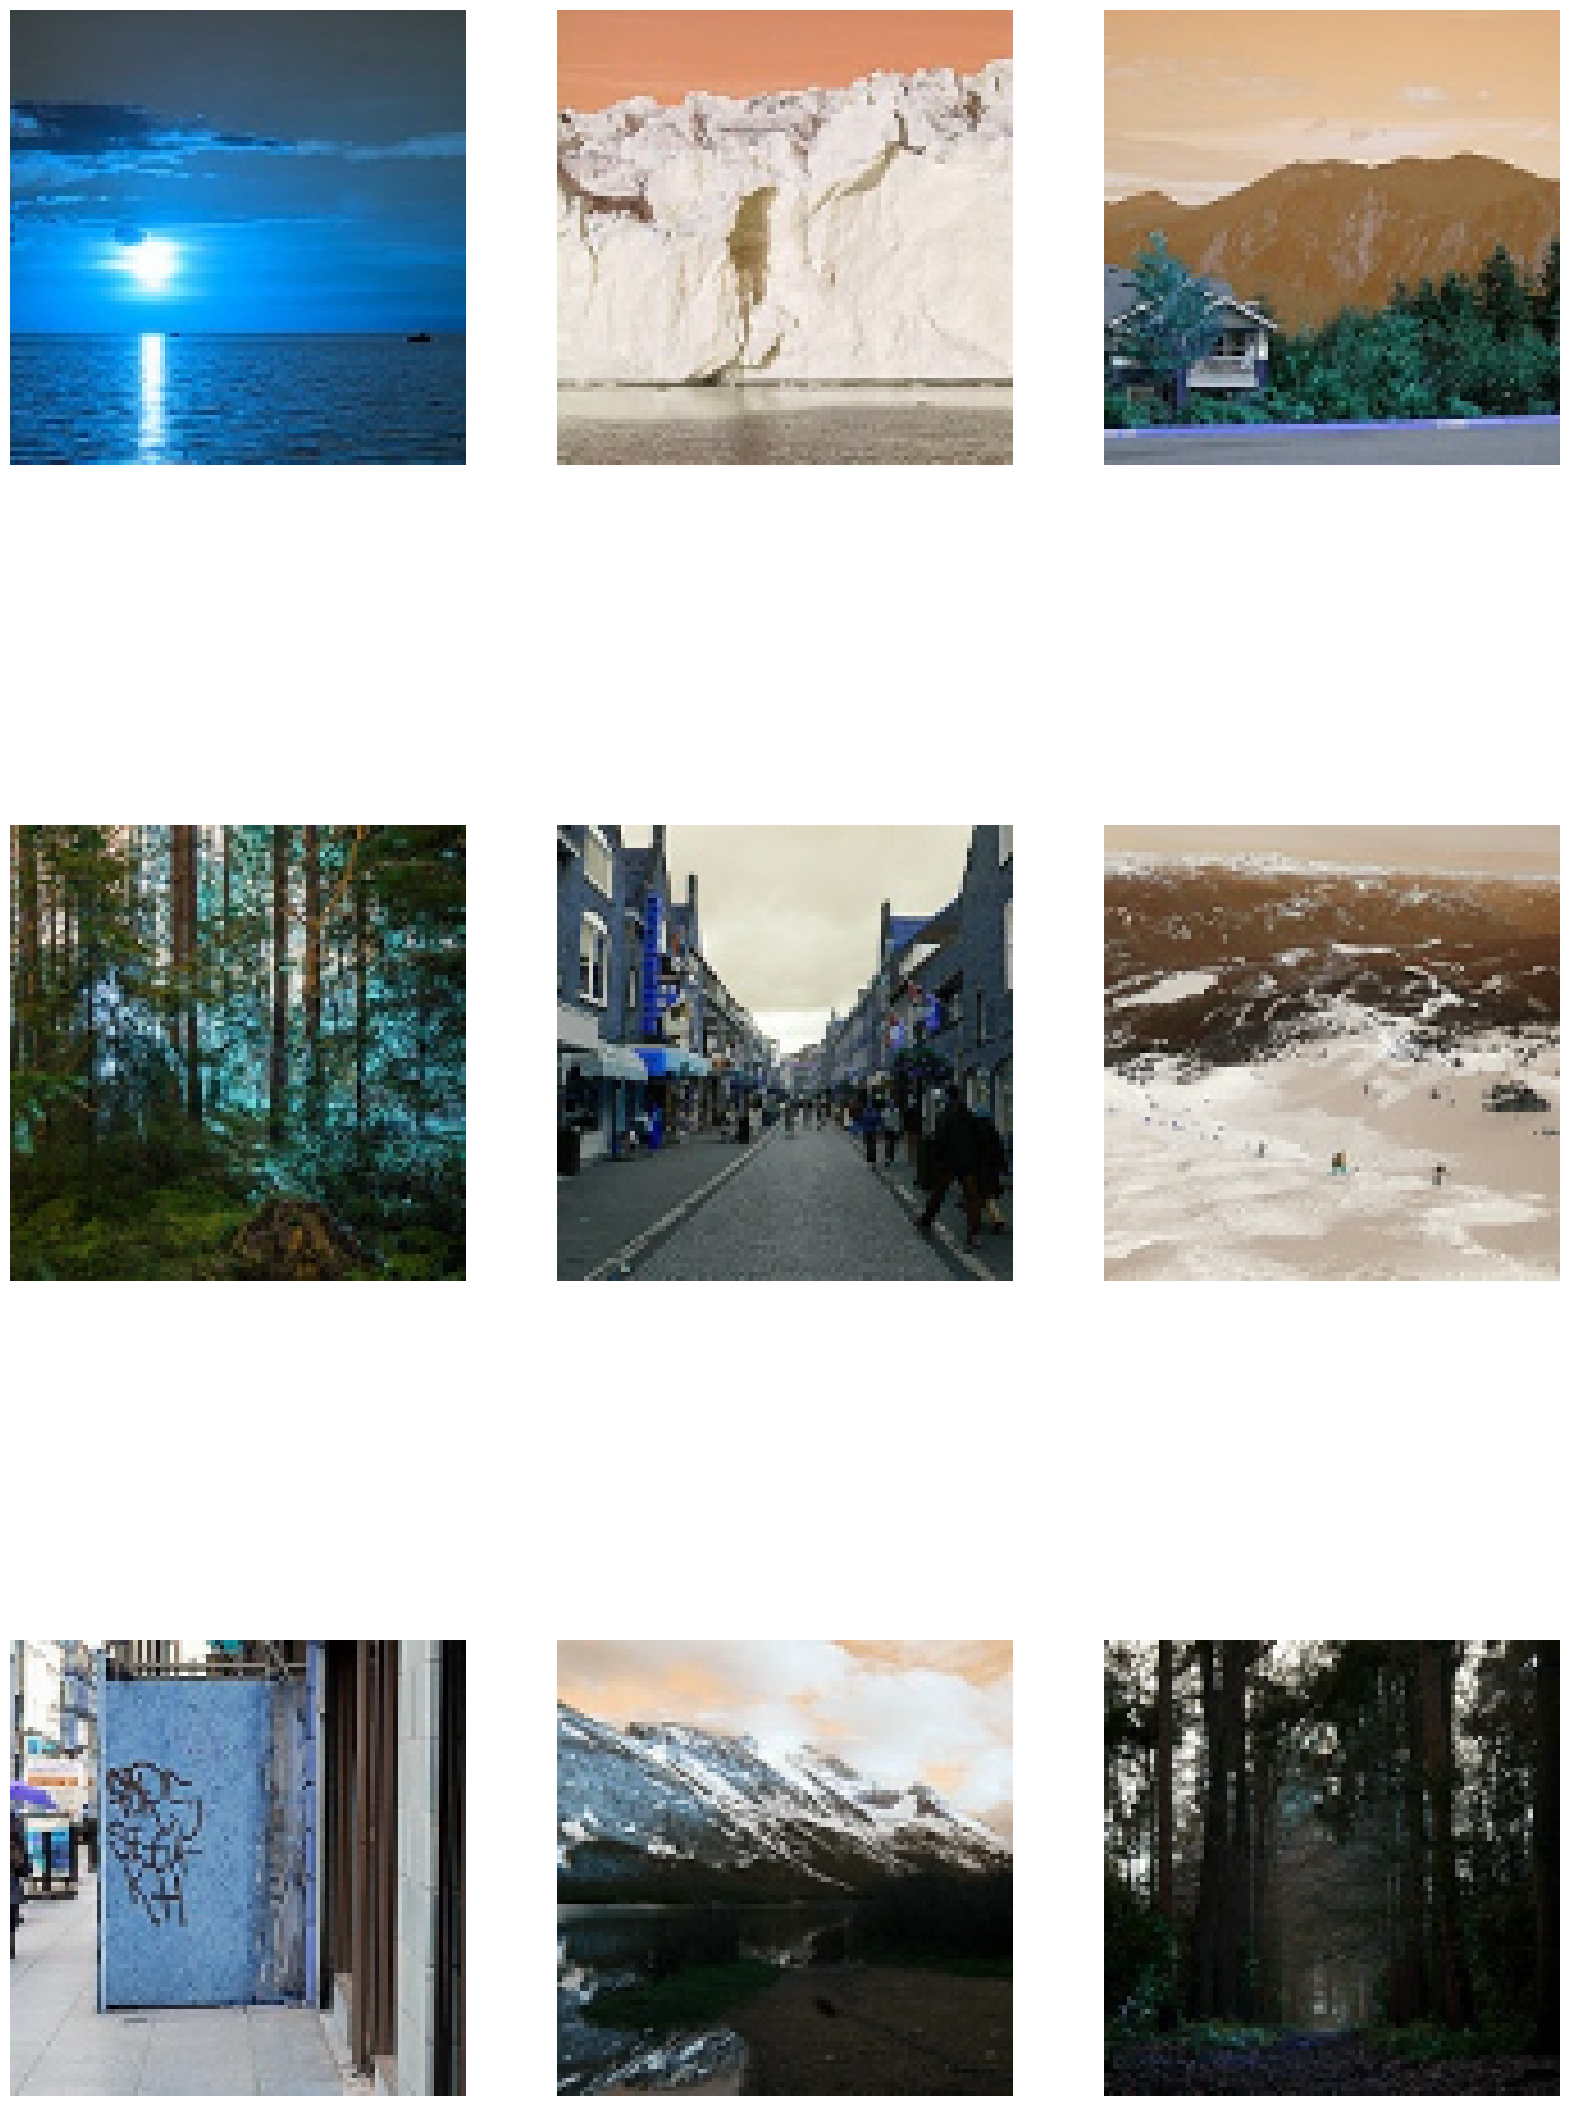

In [14]:
plot_some_image(X_pred, None, 'Prediction')

In [15]:
def image_to_graph(image, new_size=(32, 32)):
    image = np.array(image)
    h, w, c = image.shape
    image = resize(image, new_size, anti_aliasing=True)
    pixels = image.reshape(-1, c)
    positions = np.column_stack(np.unravel_index(np.arange(new_size[0] * new_size[1]), (new_size[0], new_size[1])))
    tri = Delaunay(positions)
    edges = [(simplex[i], simplex[(i + 1) % 3]) for simplex in tri.simplices for i in range(3)]
    edge_index = torch.tensor(np.array(edges).T, dtype=torch.long)
    x = torch.tensor(pixels, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

def convert_dataset_to_graph(X, y=None):
    graphs = []
    for i, image in enumerate(X):
        graph = image_to_graph(image)
        if y is not None:
            graph.y = torch.tensor(y[i], dtype=torch.long)
        graphs.append(graph)
    return graphs

train_graphs = convert_dataset_to_graph(X_train, y_train)
test_graphs = convert_dataset_to_graph(X_test, y_test)

    # Create DataLoaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

In [16]:

class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dims[0])
        self.conv2 = GCNConv(hidden_dims[0], hidden_dims[1])
        self.batch_norm1 = BatchNorm(hidden_dims[1])
        self.conv3 = GCNConv(hidden_dims[1], hidden_dims[2])
        self.batch_norm2 = BatchNorm(hidden_dims[2])
        self.fc = Linear(hidden_dims[2], num_classes)
        self.relu = ReLU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = self.batch_norm1(x)
        x = self.relu(self.conv3(x, edge_index))
        x = self.batch_norm2(x)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

input_dim = 3
hidden_dims = [256, 128, 64]
num_classes = len(code)

model = GCNModel(input_dim, hidden_dims, num_classes).to(device)


In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# def train():
#     model.train()
#     total_loss = 0
#     for data in train_loader:
#         optimizer.zero_grad()
#         out = model(data)
#         loss = criterion(out, data.y)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     return total_loss / len(train_loader)

# def validate():
#     model.eval()
#     correct = 0
#     for data in test_loader:
#         out = model(data)
#         pred = out.argmax(dim=1)
#         correct += (pred == data.y).sum().item()
#     return correct / len(test_graphs)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate():
    model.eval()
    correct = 0
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(test_graphs)

In [18]:
# def save_model(model, model_dir='model', filename='gcn_dt.pth'):
#     os.makedirs(model_dir, exist_ok=True)
#     save_path = os.path.join(model_dir, filename)
    
#     torch.save(model.state_dict(), save_path)
#     print(f"Model successfully saved to: {save_path}")

## ========================= Run on Kaggle =========================

def save_model(model, model_dir='/kaggle/working', filename='gcn_dt.pth'):
    os.makedirs(model_dir, exist_ok=True)
    save_path = os.path.join(model_dir, filename)
    
    torch.save(model.state_dict(), save_path)
    print(f"✅ Model successfully saved to: {save_path}")

In [19]:
num_epochs = 200
patience = 20  # số epoch tối đa không cải thiện trước khi dừng
best_val_acc = 0.0
epochs_no_improve = 0

for epoch in range(1, num_epochs + 1):
    train_loss = train()
    val_acc = validate()
    
    print(f'Epoch {epoch}, Loss: {train_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        save_model(model)
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Stopping early at epoch {epoch} due to no improvement in validation accuracy for {patience} epochs.')
        break


Epoch 1, Loss: 1.3136, Validation Accuracy: 0.5110
✅ Model successfully saved to: /kaggle/working/gcn_dt.pth
Epoch 2, Loss: 1.2431, Validation Accuracy: 0.4647
Epoch 3, Loss: 1.2277, Validation Accuracy: 0.5203
✅ Model successfully saved to: /kaggle/working/gcn_dt.pth
Epoch 4, Loss: 1.2129, Validation Accuracy: 0.5107
Epoch 5, Loss: 1.2040, Validation Accuracy: 0.5320
✅ Model successfully saved to: /kaggle/working/gcn_dt.pth
Epoch 6, Loss: 1.1952, Validation Accuracy: 0.5117
Epoch 7, Loss: 1.1929, Validation Accuracy: 0.5253
Epoch 8, Loss: 1.1862, Validation Accuracy: 0.5140
Epoch 9, Loss: 1.1833, Validation Accuracy: 0.5217
Epoch 10, Loss: 1.1789, Validation Accuracy: 0.5367
✅ Model successfully saved to: /kaggle/working/gcn_dt.pth
Epoch 11, Loss: 1.1765, Validation Accuracy: 0.5200
Epoch 12, Loss: 1.1790, Validation Accuracy: 0.5333
Epoch 13, Loss: 1.1684, Validation Accuracy: 0.5410
✅ Model successfully saved to: /kaggle/working/gcn_dt.pth
Epoch 14, Loss: 1.1691, Validation Accuracy

In [20]:
# def evaluate(model, test_loader, criterion):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for data in test_loader:
#             out = model(data)
#             loss = criterion(out, data.y)
#             total_loss += loss.item()
#             pred = out.argmax(dim=1)
#             correct += (pred == data.y).sum().item()
#             total += data.y.size(0)
#     avg_loss = total_loss / len(test_loader)
#     accuracy = correct / total

#     return avg_loss, accuracy

def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total

    return avg_loss, accuracy


# Evaluate the model
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_accuracy))


Test Loss: 1.1733
Test Accuracy: 0.5653


In [21]:
model.eval()
all_outputs = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        all_outputs.append(out)
y_test_pred = torch.cat(all_outputs, dim=0)
print(f'Prediction Shape: {y_test_pred.shape}')

Prediction Shape: torch.Size([3000, 6])


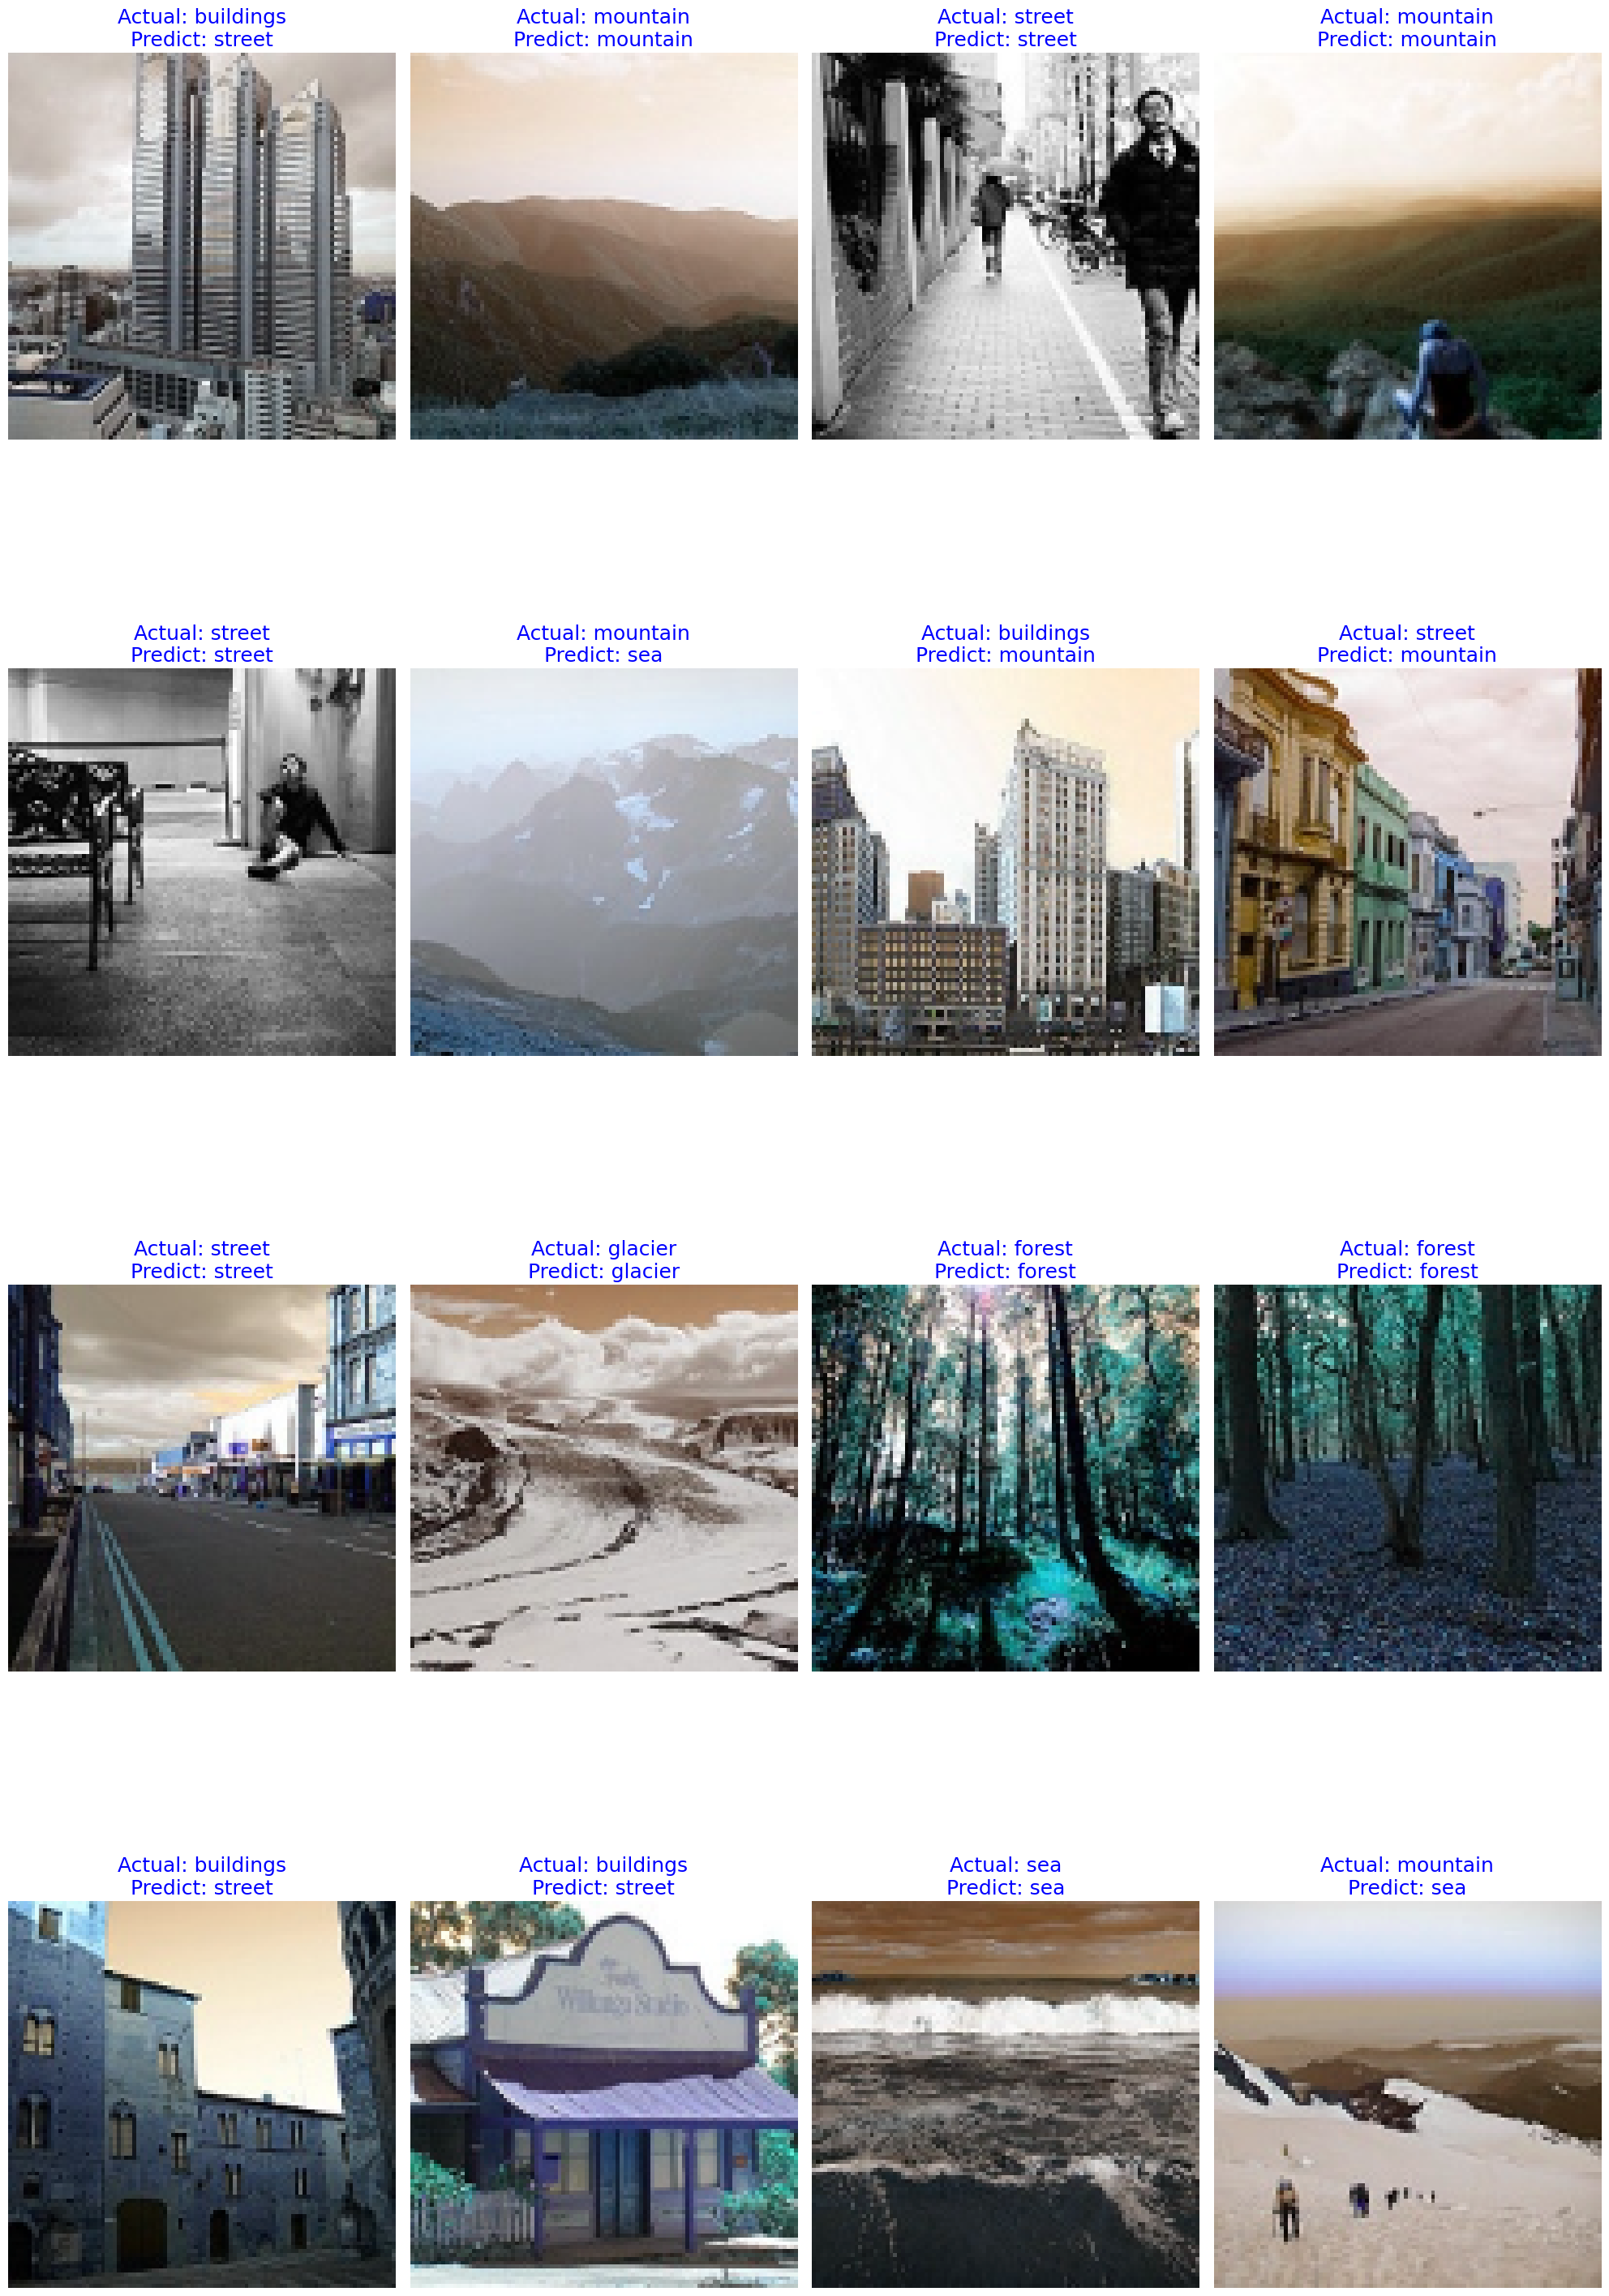

In [22]:
plt.figure(figsize=(20, 32))

selected_indices = list(np.random.randint(0, len(X_test), 16))

for n, i in enumerate(selected_indices):
    plt.subplot(4, 4, n + 1)

    img = np.array(X_test[i])
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img)
    plt.axis('off')

    actual_label = get_name(y_test[i])
    predicted_label = get_name(np.argmax(y_test_pred[i].cpu().numpy()))

    plt.title(f'Actual: {actual_label}\nPredict: {predicted_label}', fontdict={'fontsize': 18, 'color': 'blue'})

plt.tight_layout()
plt.show()


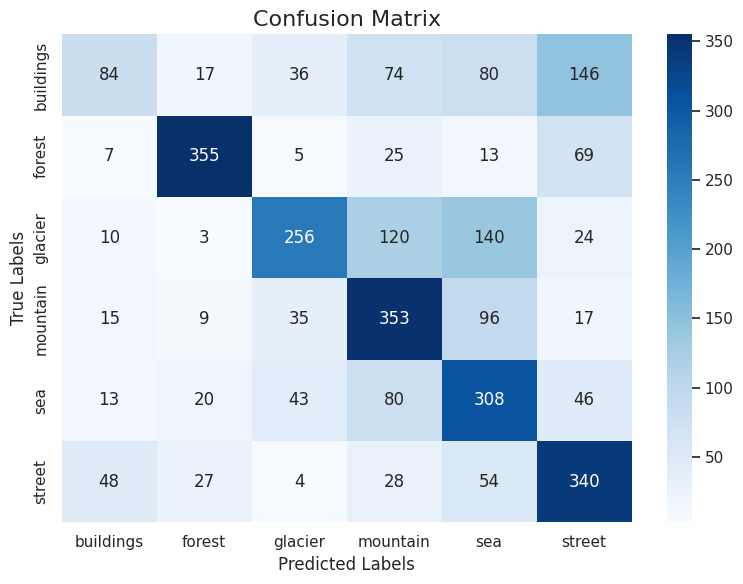

In [23]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.tight_layout()
    plt.show()

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
pred_labels = np.argmax(y_test_pred.cpu().numpy(), axis=1)
plot_confusion_matrix(y_test, pred_labels, class_names)


---

# 🔍 **Đánh giá Confusion Matrix**

---

## ✅ **Lớp được mô hình phân loại tốt**

| **Lớp**      | **Số mẫu phân loại đúng** | **Nhận xét**                                                    |
| ------------ | ------------------------- | --------------------------------------------------------------- |
| **forest**   | 355                       | Mô hình phân biệt rất tốt, gần như không nhầm với các lớp khác. |
| **mountain** | 353                       | Hiệu suất cao, chỉ nhầm một phần nhỏ với các lớp tương tự.      |
| **street**   | 340                       | Nhận diện tốt, dù vẫn có nhầm lẫn với `buildings` và `sea`.     |

---

## ⚠️ **Lớp có độ chính xác thấp**

| **Lớp**       | **Số mẫu phân loại đúng** | **Nhận xét**                                                                                  |
| ------------- | ------------------------- | --------------------------------------------------------------------------------------------- |
| **buildings** | 84                        | Nhầm rất nhiều với `street` (146), `mountain` (74), và `sea` (80) — hiệu suất thấp.           |
| **glacier**   | 256                       | Bị nhầm đáng kể với `mountain` (120) và `sea` (140), cần cải thiện.                           |
| **sea**       | 308                       | Dù đúng nhiều, vẫn có nhầm lẫn đáng kể với `mountain` (80), `glacier` (43), và `street` (46). |

---

## 🔄 **Các cặp lớp thường bị nhầm lẫn**

| **Cặp lớp bị nhầm**    | **Số lượng nhầm lẫn** | **Nhận xét**                                                     |
| ---------------------- | --------------------- | ---------------------------------------------------------------- |
| `buildings` → `street` | 146                   | Nhầm lẫn nghiêm trọng, có thể do sự tương đồng cảnh quan đô thị. |
| `glacier` → `sea`      | 140                   | Hai lớp có đặc điểm màu sắc, texture gần giống nhau.             |
| `glacier` → `mountain` | 120                   | Khó phân biệt do hình ảnh băng tuyết trên núi.                   |
| `sea` → `mountain`     | 80                    | Có thể là ảnh vùng biển gần núi hoặc do đặc trưng vùng ven.      |
| `street` → `buildings` | 48                    | Mô hình khó tách biệt cảnh đường phố có nhiều tòa nhà.           |

---

## 🧾 **Kết luận**

* Mô hình hoạt động tốt với các lớp như `forest`, `mountain`, và `street`.
* Các lớp như `glacier` và `buildings` bị nhầm nhiều do đặc điểm hình ảnh trùng lặp hoặc nhiễu.
* **Cần cải thiện phân biệt giữa:**

  * `buildings` ↔ `street`
  * `glacier` ↔ `sea` và `mountain`
  * `sea` ↔ `mountain`

---

In [24]:
def load_model(model, path='/kaggle/working/gcn_dt.pth'):
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    print(f"Model loaded from {path}")
    return model

loaded_model = GCNModel(input_dim=3, hidden_dims=[256, 128, 64], num_classes=6)
loaded_model = load_model(loaded_model)

Model loaded from /kaggle/working/gcn_dt.pth


In [25]:
# Hàm xử lý ảnh từ URL
# def predict_from_url(url, model):
#     # Tải ảnh từ URL
#     response = requests.get(url)
#     img = Image.open(io.BytesIO(response.content))
    
#     # Tiền xử lý ảnh
#     img = img.convert('RGB')
#     img = np.array(img)
#     img = cv2.resize(img, (100, 100))  # Kích thước phù hợp với model
    
#     # Chuyển đổi thành đồ thị
#     graph = image_to_graph(img)
    
#     # Dự đoán
#     with torch.no_grad():
#         output = model(graph)
#         pred = output.argmax(dim=1).item()
    
#     # Hiển thị kết quả
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(f'Predicted: {get_name(pred)}')
#     plt.show()
    
#     return get_name(pred)

def predict_from_url(url, model):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    img = img.convert('RGB')
    img = np.array(img)
    img = cv2.resize(img, (100, 100))
    graph = image_to_graph(img)
    graph = graph.to(device).cpu()

    with torch.no_grad():
        output = model(graph)
        pred = output.argmax(dim=1).item()

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {get_name(pred)}')
    plt.show()

    return get_name(pred)


In [26]:
urls = [
    "https://cdn.pixabay.com/photo/2017/03/28/21/44/autumn-2183489_640.jpg",
    "https://media.istockphoto.com/id/1360554439/vi/anh/%C4%91%E1%BA%A3o-nhi%E1%BB%87t-%C4%91%E1%BB%9Bi-maldives.jpg?s=612x612&w=0&k=20&c=pqWxvBFhn0_mJQF-oNyiDS56iahHule2vZmmVbjc_TA=",
    "https://vanphongchothue.vn/uploads/noidung/images/toa-thap-view-dep-nhat-thanh-pho-ho-chi-minh.jpg"
]

Predicting image from https://cdn.pixabay.com/photo/2017/03/28/21/44/autumn-2183489_640.jpg


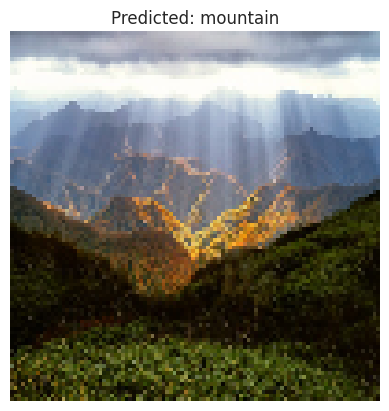

Prediction result: mountain

Predicting image from https://media.istockphoto.com/id/1360554439/vi/anh/%C4%91%E1%BA%A3o-nhi%E1%BB%87t-%C4%91%E1%BB%9Bi-maldives.jpg?s=612x612&w=0&k=20&c=pqWxvBFhn0_mJQF-oNyiDS56iahHule2vZmmVbjc_TA=


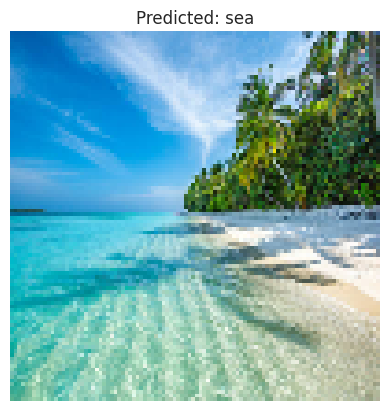

Prediction result: sea

Predicting image from https://vanphongchothue.vn/uploads/noidung/images/toa-thap-view-dep-nhat-thanh-pho-ho-chi-minh.jpg


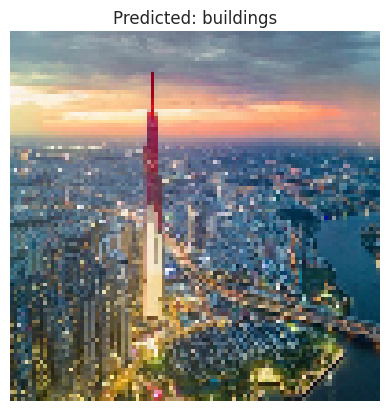

Prediction result: buildings



In [27]:
for url in urls:
    try:
        print(f"Predicting image from {url}")
        prediction = predict_from_url(url, loaded_model)
        print(f"Prediction result: {prediction}\n")
    except Exception as e:
        print(f"Error processing {url}: {str(e)}\n")